In [ ]:
from functions.functions import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from functions.functions_time_model import *
from functions.functions_different_inputs import *

#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop import LpLoss, H1Loss
from neuralop.training import BasicLoggerCallback

# FNO - 2nd Architecture

## low energy states

In [ ]:
from functions.seed_utilis import *

seed=2
set_seed(seed) 

In [22]:
# Define parameters
n = 4  # Number of particles
num_states = 10000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
modes= (2**n)//2 #+1
hidden_channels=128
input_t=15
output_t=10
populated_states=3
epochs=50
proj_lift_channel=256
lr=1e-3

In [23]:
hamiltonian= construct_hamiltonian(n)
time=0.314
steps =100
dataset=create_time_data_set_low_energy_states(n,num_states,populated_states,hamiltonian,time,steps)

In [24]:
train_loader,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)

[Dataset] x_train: torch.Size([8000, 18, 15]), y_train: torch.Size([8000, 16, 15])
[Dataset] x_test: torch.Size([2000, 18, 15]), y_test: torch.Size([2000, 16, 15])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2**n+2,
        out_channels=2**n,
        Complex=True,
        arch_no=2,
        lifting_channels=proj_lift_channel,
        projection_channels=proj_lift_channel)
model = model.to('cuda')

In [26]:
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=1e-4) 
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)

In [27]:
#l2loss = LpLoss(d=2, p=2)
#h1loss = H1Loss(d=2)

l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2,reductions=['sum','mean']) 
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0, 1])
    return loss.real

train_loss = mse_loss # h1loss
eval_losses={'h1': h1loss, 'l2': l2loss,'mse':mse_loss}

In [28]:
import wandb
    
config = { 
    "No_of_particles": n,
    "batch_size": batch_size,
    "n_train": num_states * train_ratio,
    "n_test": num_states * (1 - train_ratio),
    "learning_rate": lr,
    "hidden_channel": hidden_channels,
    "proj/lift": proj_lift_channel,
    "epochs": epochs,
}


project="fno_arch_2_low"
name="fno_low"
entity= "fs1132429_" # put your username here


wandb_init_args = dict(
        config=config,
        project=project,
        name=name,
        entity=entity,
    )

In [29]:
device='cuda'

callbacks = [
    BasicLoggerCallback(wandb_init_args)
]

trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    callbacks=callbacks,
    data_processor=None,
    wandb_log=True,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)

avg_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loader_mse,█▂▂▂▄▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,█▂▁▃▃▃▂▃▂▂▅▃▃▃▃▃▃▃▄▂▂▃▂▃▃▃▃▂▄▃▃▂▁▃▃▄▃▃▃▃
train_err,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,0.0
lr,1e-05
test_loader_h1,inf
test_loader_l2,inf
test_loader_mse,0.0
time,2.52194


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False
Training on 8000 samples
Testing on [2000] samples         on resolutions ['test_loader'].
Raw outputs of size out.shape=torch.Size([32, 16, 15])
[0] time=2.70, avg_loss=0.1201, train_err=3.8420, test_loader_h1=inf, test_loader_l2=inf, test_loader_mse=0.0003
[1] time=2.66, avg_loss=0.0001, train_err=0.0048, test_loader_h1=inf, test_loader_l2=inf, test_loader_mse=0.0001
[2] time=2.73, avg_loss=0.0001, train_err=0.0022, test_loader_h1=inf, test_loader_l2=inf, test_loader_mse=0.0001
[3] time=2.70, avg_loss=0.0000, train_err=0.0015, test_loader_h1=inf, test_loader_l2=inf, test_loader_mse=0.0000
[4] time=2.64, avg_loss=0.0000, train_err=0.0010, test_loader_h1=inf, test_loader_l2=inf, test_loader_mse=0.0000
[5] time=2.54, avg_loss=0.0000, train_err=0.0008, test_loader_h1=inf, test_loader_l2=inf, test_loader_mse=0.0000
[6] time=2.57, avg_loss=0.0000

{'test_loader_h1': inf,
 'test_loader_l2': inf,
 'test_loader_mse': 3.966625066823326e-06}

[Dataset] x_train: torch.Size([800, 18, 15]), y_train: torch.Size([800, 16, 15])
[Dataset] x_test: torch.Size([200, 18, 15]), y_test: torch.Size([200, 16, 15])


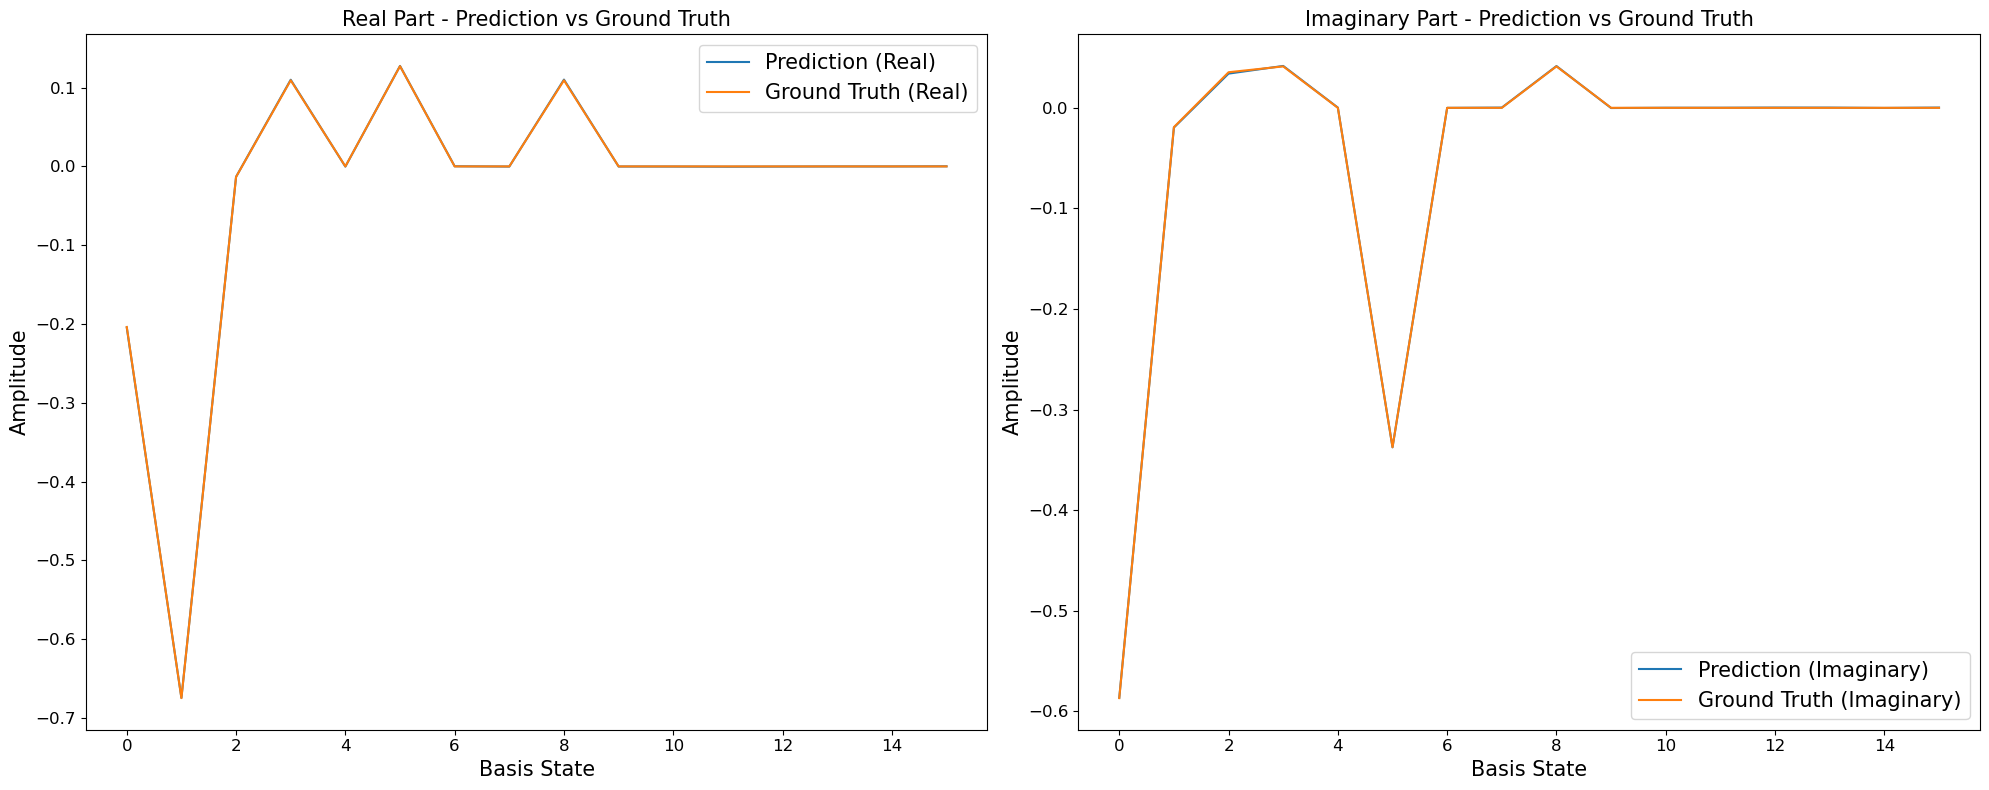

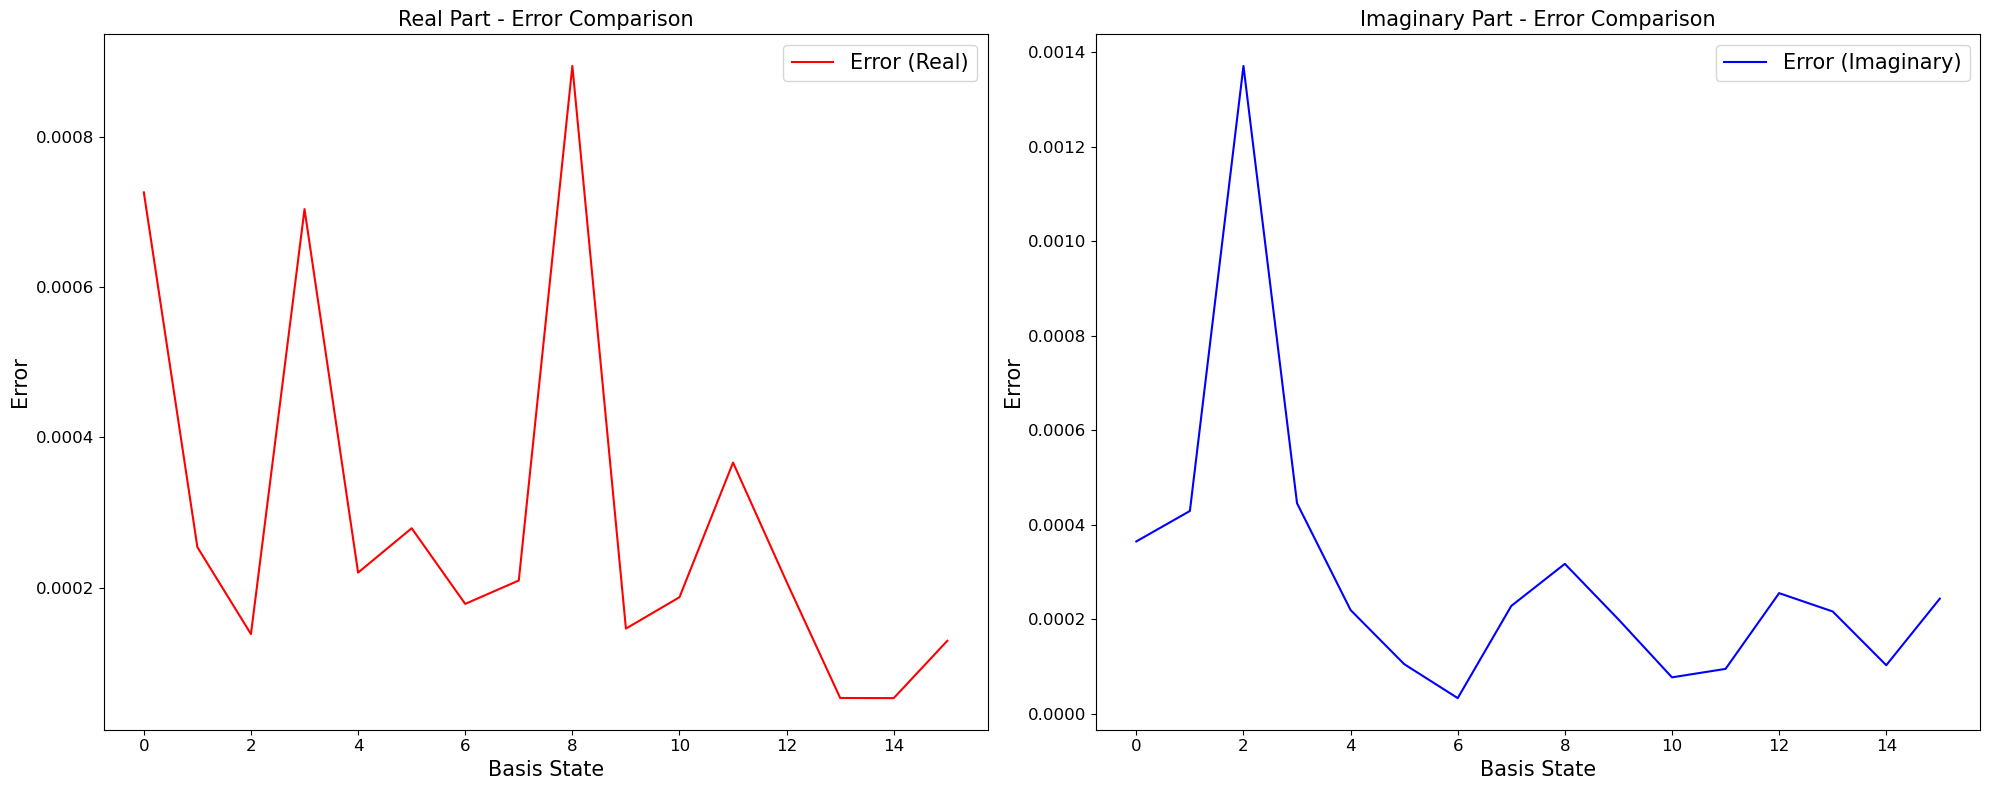

In [30]:
n= 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

dataset=create_time_data_set_low_energy_states(n,num_states,populated_states,hamiltonian,time,steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.cpu())
    ground_truth_list.append(y.cpu())

# Concatenate predictions and ground truth across batches
predictions = torch.cat(predictions_list,dim=0)
ground_truth = torch.cat(ground_truth_list,dim=0)

# Plot the comparison with error
plot_comparison_with_error2(predictions[0,:,1], ground_truth[0,:,1])  # Plot for the first sample in the dataset


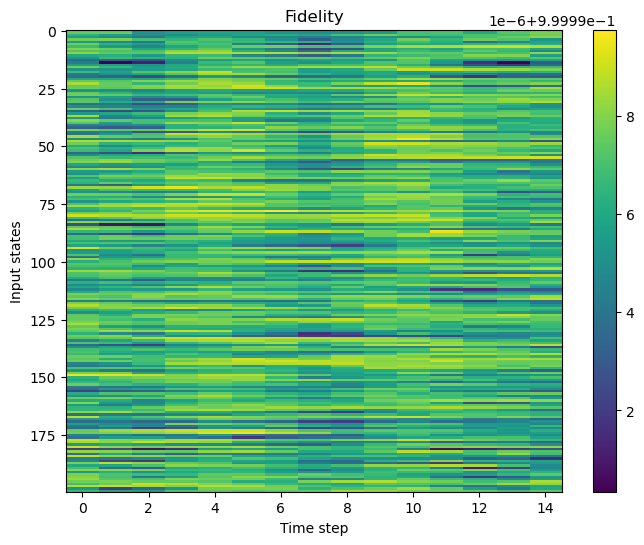

In [31]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

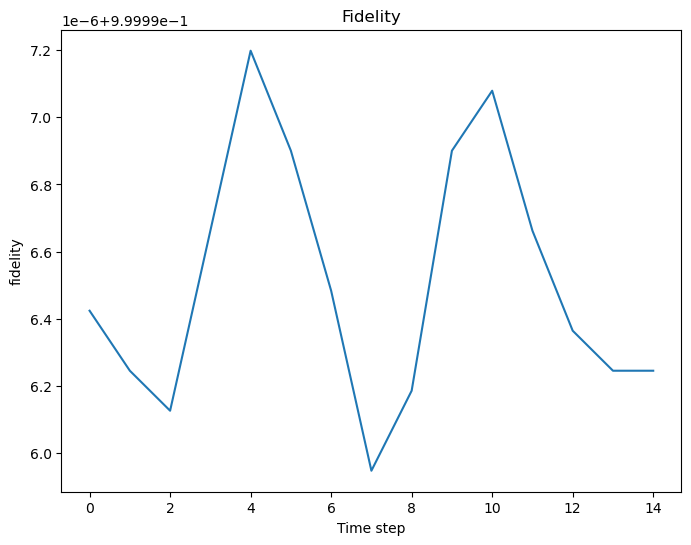

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [33]:
print(mean_total)

tensor(1.0000)


## autoregressive rollout

In [34]:
# Example usage
from neuralop.layers.embeddings import PositionalEmbedding

N=n
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps
times=0.314
spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()
hamiltonian= construct_hamiltonian(N)
steps=200

start_index=0
timesteps = torch.linspace(start_index, start_index+input_t,input_t)
pos_embedding = PositionalEmbedding(2)
positional_embeddings = pos_embedding(timesteps)
pos=positional_embeddings.T.repeat(batch_size, 1, 1)


dataset=create_time_data_set_low_energy_states(N,num_states,populated_states,hamiltonian,times, steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
train_size = int(train_ratio * num_states)
dataset1=dataset[train_size:,:,:]
predictions, ground_truth = autoregressive_rollout2(model,test_loader, dataset1,rollout_steps,pos.cuda(),output_t,input_t,overlap=True)


[Dataset] x_train: torch.Size([800, 18, 15]), y_train: torch.Size([800, 16, 15])
[Dataset] x_test: torch.Size([200, 18, 15]), y_test: torch.Size([200, 16, 15])
10
20
30
40
50
60
70
80
90
100


In [35]:
predictions = predictions.cpu()
ground_truth=ground_truth.cpu()
print(predictions.shape)
print(ground_truth.shape)

torch.Size([200, 16, 150])
torch.Size([200, 16, 150])


In [36]:
wavefunction_gt= ground_truth[180,:,:50]
wavefunction_pr= predictions[180,:,:50]

pop_gt= torch.abs(wavefunction_gt)**2
pop_pr= torch.abs(wavefunction_pr)**2



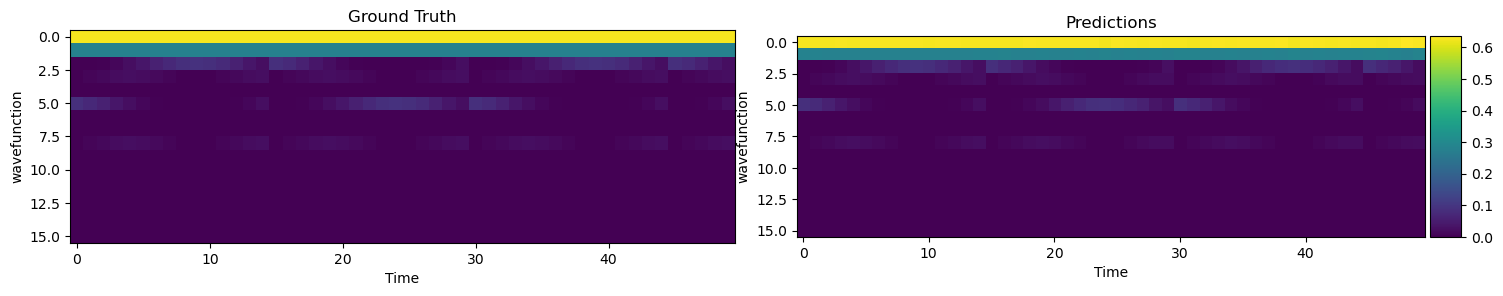

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a figure with 2 subplots in a row
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Define a common normalization for both plots
vmin = min(pop_gt.min(), pop_pr.min())
vmax = max(pop_gt.max(), pop_pr.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# First plot
im1 = axs[0].imshow(pop_gt, cmap='viridis', norm=norm)
axs[0].set_xlabel("Time")
axs[0].set_ylabel("wavefunction")
axs[0].set_title("Ground Truth")

# Second plot
im2 = axs[1].imshow(pop_pr, cmap='viridis', norm=norm)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("wavefunction")
axs[1].set_title("Predictions")

# Create an axis on the right side of the figure for the color bar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add the color bar to the new axis
fig.colorbar(im1, cax=cax)

plt.tight_layout()

# Show the plots
plt.show()


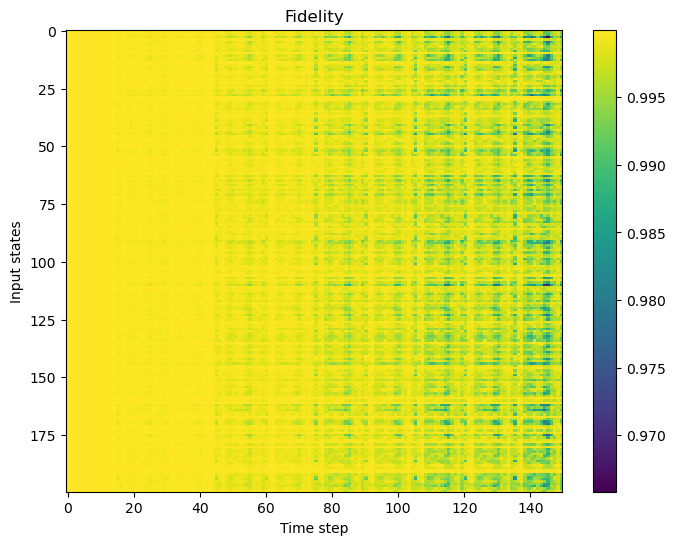

In [38]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

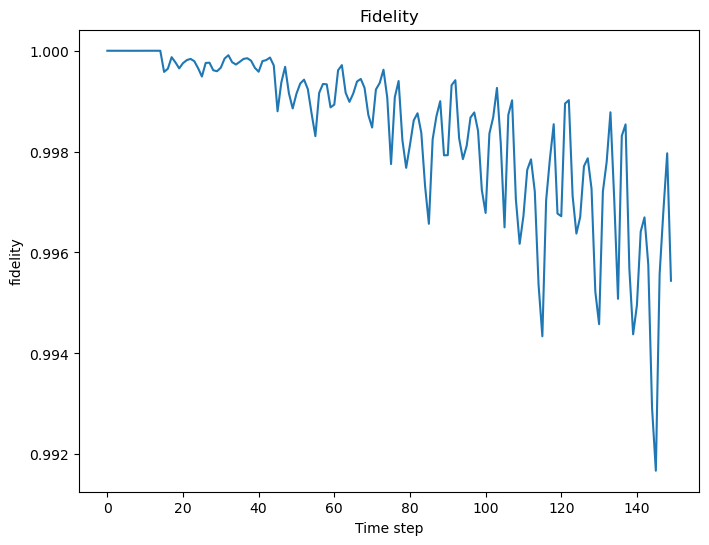

In [39]:

plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [40]:
print(mean_total)

tensor(0.9984)


## states ordered by population

In [27]:
# Define parameters
n = 4  # Number of particles
num_states = 10000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
modes= (2**n)//2 #+1
hidden_channels=64
input_t=15
output_t=15


In [28]:
hamiltonian= construct_hamiltonian(n)
time=0.314
steps =100
dataset=create_time_data_set_sorted_by_population(n,num_states,hamiltonian,time,steps)

In [29]:
train_loader,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)

[Dataset] x_train: torch.Size([8000, 18, 15]), y_train: torch.Size([8000, 16, 15])
[Dataset] x_test: torch.Size([2000, 18, 15]), y_test: torch.Size([2000, 16, 15])


In [30]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2**n+2,
        out_channels=2**n,
        spatial_domain= 'complex')
model = model.to('cuda')

In [31]:
optimizer = torch.optim.Adam(model.parameters(),lr=8e-3,weight_decay=1e-4)
#optimizer = torch.optim.SGD(model.parameters(),lr=10e-3,momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [32]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [33]:

epochs=50
device='cuda'

trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    data_processor=None,
    wandb_log=False,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)

self.override_load_to_device=False
self.overrides_loss=False


{'test_loader_h1': 0.03980170765519142, 'test_loader_l2': 0.04104931974411011}

[Dataset] x_train: torch.Size([800, 18, 15]), y_train: torch.Size([800, 16, 15])
[Dataset] x_test: torch.Size([200, 18, 15]), y_test: torch.Size([200, 16, 15])


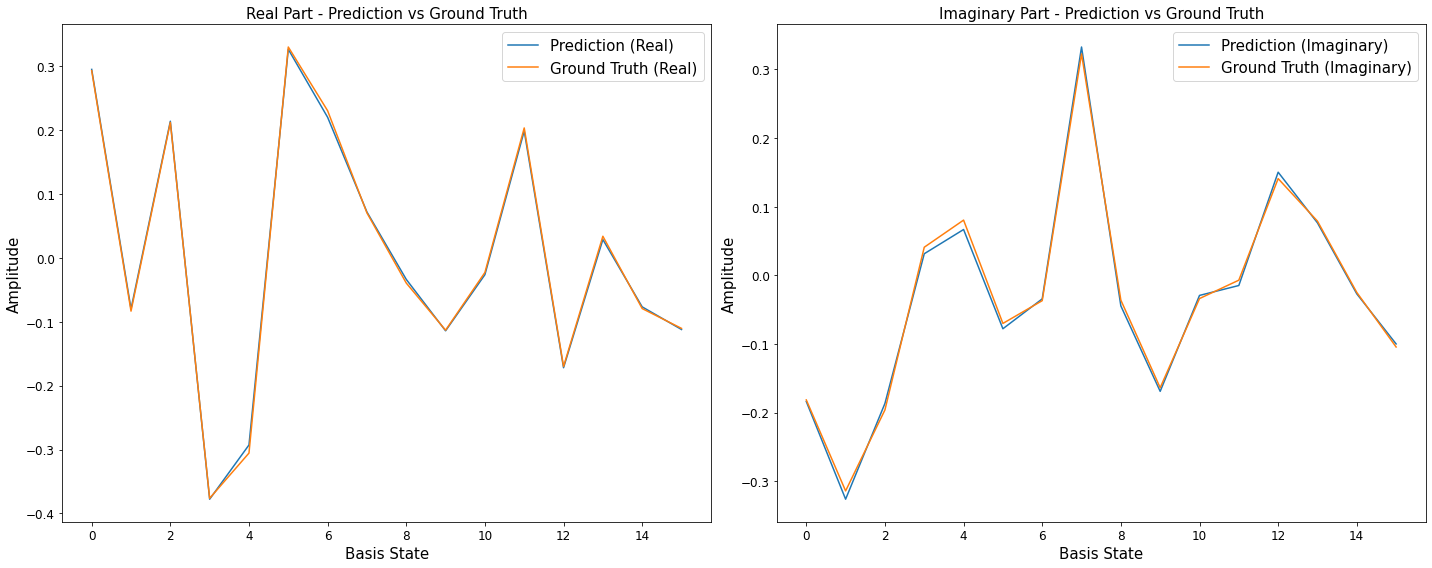

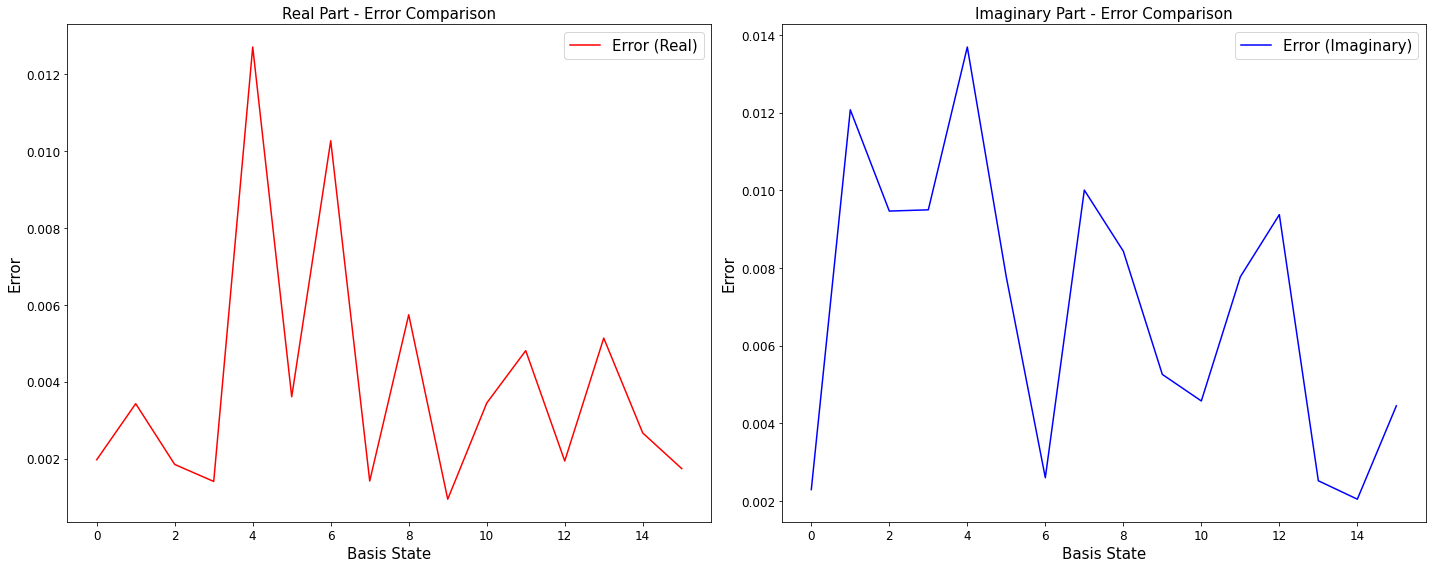

In [34]:
n= 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

dataset=create_time_data_set_sorted_by_population(n,num_states,hamiltonian,time,steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.cpu())
    ground_truth_list.append(y.cpu())

# Concatenate predictions and ground truth across batches
predictions = torch.cat(predictions_list,dim=0)
ground_truth = torch.cat(ground_truth_list,dim=0)

# Plot the comparison with error
plot_comparison_with_error2(predictions[0,:,1], ground_truth[0,:,1])  # Plot for the first sample in the dataset


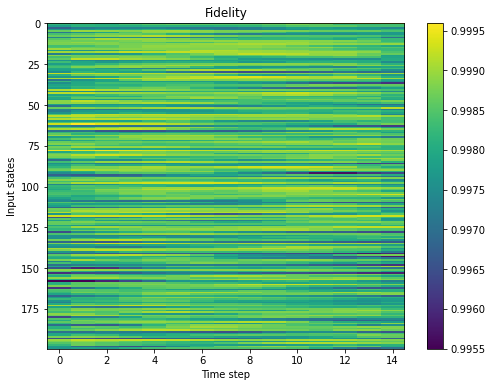

In [35]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

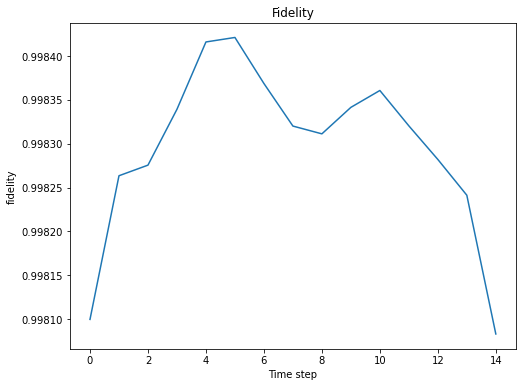

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [37]:
print(mean_total)

tensor(0.9983)


## autoregressive rollout

In [38]:
# Example usage
from neuralop.layers.embeddings import PositionalEmbedding

N = 4  # Number of particles
num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps
times=0.314
spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()
hamiltonian= construct_hamiltonian(N)
steps=200
input_t=15
output_t=15
start_index=0
timesteps = torch.linspace(start_index, start_index+input_t,input_t)
pos_embedding = PositionalEmbedding(2)
positional_embeddings = pos_embedding(timesteps)
pos=positional_embeddings.T.repeat(batch_size, 1, 1)

dataset=create_time_data_set_sorted_by_population(N,num_states,hamiltonian,times, steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
train_size = int(train_ratio * num_states)
dataset1=dataset[train_size:,:,:]
predictions, ground_truth = autoregressive_rollout2(model,test_loader, dataset1,rollout_steps,pos.cuda(),output_t,input_t)


[Dataset] x_train: torch.Size([800, 18, 15]), y_train: torch.Size([800, 16, 15])
[Dataset] x_test: torch.Size([200, 18, 15]), y_test: torch.Size([200, 16, 15])


In [39]:
predictions = predictions.cpu()
ground_truth=ground_truth.cpu()
print(predictions.shape)
print(ground_truth.shape)

torch.Size([200, 16, 150])
torch.Size([200, 16, 150])


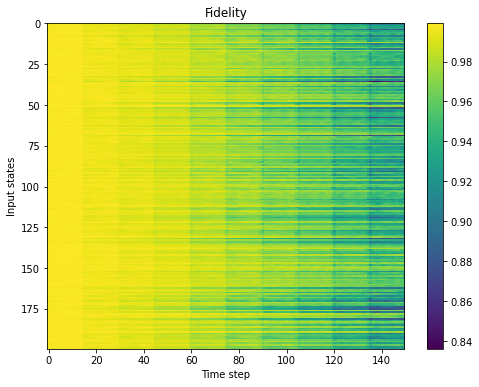

In [40]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

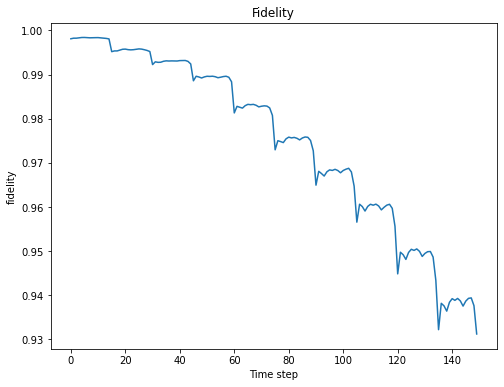

In [41]:

plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [42]:
print(mean_total)

tensor(0.9747)
